In [127]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 30)

In [ ]:
# Requirements: nfl-big-data-bowl-2024 csvs
# WARNING: messy, didn't have time to clean it

In [128]:
INPUT_DIR = '/kaggle/input/nfl-big-data-bowl-2024'

In [129]:
def preprocess_df(df_train):
    min_frame_ids = df_train[df_train['event'].isin(['first_contact'])].groupby(['gameId', 'playId'])['frameId'].min()
    df_train = df_train.merge(min_frame_ids.reset_index(), on=['gameId', 'playId'], suffixes=('', '_min'))
    max_frame_ids = df_train[df_train['event'].isin(['tackle'])].groupby(['gameId', 'playId'])['frameId'].max()
    df_train = df_train.merge(max_frame_ids.reset_index(), on=['gameId', 'playId'], suffixes=('', '_max'))
    
    # get frames between first contact and tackle
    df_train = df_train[df_train['frameId'] <= df_train['frameId_max']+1].drop(columns=['frameId_max']).reset_index(drop=True)
    df_train = df_train[df_train['frameId'] >= df_train['frameId_min']].drop(columns=['frameId_min']).reset_index(drop=True)
    
    # get average velocity vector
    df_train['nflId'] = df_train['nflId'].fillna(-1)
    df_train['x_diff'] = df_train.groupby(['gameId', 'playId', 'nflId'])['x'].diff().shift(-1)
    df_train['y_diff'] = df_train.groupby(['gameId', 'playId', 'nflId'])['y'].diff().shift(-1)
    df_train = df_train.dropna(subset=['x_diff', 'y_diff'])
    
    # add player heights and weights
    df_players = pd.read_csv(f"{INPUT_DIR}/players.csv")[['nflId','position','height', 'weight']]
    df_players['height'] = df_players['height'].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]))
    df_players[['height', 'weight']] = df_players[['height', 'weight']].apply(lambda x: (x - x.mean()) / x.std())
    df_train = df_train.merge(df_players, on=['nflId'], how='left')

    # add other features
    df_plays =  pd.read_csv(f"{INPUT_DIR}/plays.csv")[['gameId','playId', 'ballCarrierId','possessionTeam']]
    df_train = df_train.merge(df_plays, on=['gameId','playId'])
    df_train['isballcarrier'] = df_train.apply(lambda row: row['nflId'] == row['ballCarrierId'], axis=1)
    df_train['offense'] = df_train.apply(lambda row: row['club'] == row['possessionTeam'] and not pd.isnull(row['possessionTeam']), axis=1)
    df_train = df_train.drop(columns=['ballCarrierId','club','possessionTeam'])
    return df_train

In [130]:
week_start = 1
week_end = 6
df_train = None
for i in range(week_start,week_end):
    if df_train is None:
        df_train = pd.read_csv(f"{INPUT_DIR}/tracking_week_{i}.csv").drop(columns=['time','jerseyNumber'])
    else:
        df_train = pd.concat([df_train,pd.read_csv(f"{INPUT_DIR}/tracking_week_{i}.csv").drop(columns=['time','jerseyNumber'])])
        
df_train = preprocess_df(df_train)
df_train.head()

,gameId,playId,nflId,displayName,frameId,playDirection,x,y,s,a,dis,o,dir,event,x_diff,y_diff,position,height,weight,isballcarrier,offense
0,2022090800,80,35472.0,Rodger Saffold,20,left,82.24,26.60,1.84,0.32,0.20,324.35,315.14,first_contact,-0.13,0.13,G,1.037265,1.682446,False,True
1,2022090800,80,35472.0,Rodger Saffold,21,left,82.11,26.73,1.82,0.54,0.19,327.40,315.01,NaN,-0.16,0.12,G,1.037265,1.682446,False,True
2,2022090800,80,35472.0,Rodger Saffold,22,left,81.95,26.85,1.83,0.66,0.20,321.55,311.31,NaN,-0.15,0.12,G,1.037265,1.682446,False,True
3,2022090800,80,35472.0,Rodger Saffold,23,left,81.80,26.97,1.81,0.79,0.19,319.59,308.85,NaN,-0.15,0.12,G,1.037265,1.682446,False,True
4,2022090800,80,35472.0,Rodger Saffold,24,left,81.65,27.09,1.79,0.84,0.19,318.73,307.50,NaN,-0.17,0.11,G,1.037265,1.682446,False,True


In [131]:
week_start = 6
week_end = 10
df_valid = None
for i in range(week_start,week_end):
    if df_valid is None:
        df_valid = pd.read_csv(f"{INPUT_DIR}/tracking_week_{i}.csv").drop(columns=['time','jerseyNumber'])
    else:
        df_valid = pd.concat([df_valid,pd.read_csv(f"{INPUT_DIR}/tracking_week_{i}.csv").drop(columns=['time','jerseyNumber'])])
df_valid = preprocess_df(df_valid)
df_valid.head()

,gameId,playId,nflId,displayName,frameId,playDirection,x,y,s,a,dis,o,dir,event,x_diff,y_diff,position,height,weight,isballcarrier,offense
0,2022101300,80,42488.0,Bobby McCain,9,left,56.05,31.12,4.88,4.24,0.48,181.55,221.38,first_contact,-0.31,-0.39,FS,-1.228919,-1.140176,False,False
1,2022101300,80,42488.0,Bobby McCain,10,left,55.74,30.73,5.09,3.94,0.50,181.55,216.35,NaN,-0.29,-0.45,FS,-1.228919,-1.140176,False,False
2,2022101300,80,42488.0,Bobby McCain,11,left,55.45,30.28,5.38,4.06,0.53,179.83,210.63,NaN,-0.26,-0.48,FS,-1.228919,-1.140176,False,False
3,2022101300,80,42488.0,Bobby McCain,12,left,55.19,29.80,5.54,3.73,0.54,179.83,206.47,NaN,-0.23,-0.51,FS,-1.228919,-1.140176,False,False
4,2022101300,80,42488.0,Bobby McCain,13,left,54.96,29.29,5.69,3.30,0.56,179.83,202.63,NaN,-0.20,-0.54,FS,-1.228919,-1.140176,False,False


In [132]:
def create_plays_list(df):
    plays_list = []
    gameIds = df['gameId'].unique()
    for gameId in gameIds:
        games = df[df['gameId'] == gameId]
        playIds = games['playId'].unique()
        for playId in playIds:
            plays_list.append(games[games['playId']==playId])
    return plays_list
plays_train = create_plays_list(df_train)
plays_valid = create_plays_list(df_valid)

In [11]:
sample_play = plays_train[0]

In [138]:
sample_play

,gameId,playId,nflId,displayName,frameId,playDirection,x,y,s,a,dis,o,dir,event,x_diff,y_diff,position,height,weight,isballcarrier,offense
0,2022090800,80,35472.0,Rodger Saffold,20,left,82.240000,26.600000,1.84,0.32,0.20,324.35,315.14,first_contact,-0.130000,0.130000,G,1.037265,1.682446,False,True
1,2022090800,80,35472.0,Rodger Saffold,21,left,82.110000,26.730000,1.82,0.54,0.19,327.40,315.01,NaN,-0.160000,0.120000,G,1.037265,1.682446,False,True
2,2022090800,80,35472.0,Rodger Saffold,22,left,81.950000,26.850000,1.83,0.66,0.20,321.55,311.31,NaN,-0.150000,0.120000,G,1.037265,1.682446,False,True
3,2022090800,80,35472.0,Rodger Saffold,23,left,81.800000,26.970000,1.81,0.79,0.19,319.59,308.85,NaN,-0.150000,0.120000,G,1.037265,1.682446,False,True
4,2022090800,80,35472.0,Rodger Saffold,24,left,81.650000,27.090000,1.79,0.84,0.19,318.73,307.50,NaN,-0.170000,0.110000,G,1.037265,1.682446,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2022090800,80,-1.0,football,22,left,74.589996,40.500000,6.88,2.20,0.70,NaN,NaN,NaN,-0.419998,0.529999,NaN,NaN,NaN,False,False
157,2022090800,80,-1.0,football,23,left,74.169998,41.029999,6.67,2.37,0.68,NaN,NaN,NaN,-0.419998,0.560001,NaN,NaN,NaN,False,False
158,2022090800,80,-1.0,football,24,left,73.750000,41.590000,6.34,3.41,0.70,NaN,NaN,NaN,-0.330002,0.430000,NaN,NaN,NaN,False,False
159,2022090800,80,-1.0,football,25,left,73.419998,42.020000,5.97,3.04,0.54,NaN,NaN,NaN,-0.290001,0.450001,NaN,NaN,NaN,False,False


In [159]:
def reflect_angle_along_y(a):
    reflected_angle = (a + 180) % 360
    return reflected_angle

def preprocess_play(df_play):
    frames_data_list = []

    for frame_id, frame_data in df_play.groupby('frameId'):
        # some data is incomplete
        try:
            frame_dict = frame_data.groupby('nflId').agg({
                'x': 'first',
                'y': 'first',
                's': 'first',
                'a': 'first',
                'o': 'first',
                'dir': 'first',
                'height': 'first',
                'weight': 'first',
                'isballcarrier':'first',
                'offense':'first',
                'x_diff':'first',
                'y_diff':'first',
                'playDirection':'first',
            })

            # Heuristic scaling for normalization
            frame_dict['s'] = frame_dict['s']/5
            frame_dict['a'] = frame_dict['a']/3
            frame_dict['x'] = frame_dict['x']/30
            frame_dict['y'] = frame_dict['y']/30
            frame_dict['o'] = (frame_dict['o'] % 360)
            frame_dict['dir'] = (frame_dict['dir'] % 360)

            ball_carrier_id = frame_data[frame_data['isballcarrier'] == True]['nflId'].iloc[0]
            ball_carrier_row = frame_dict[frame_dict['isballcarrier'] == True].iloc[0]
            
            distances = np.sqrt((frame_dict['x'] - ball_carrier_row['x'])**2 + (frame_dict['y'] - ball_carrier_row['y'])**2)
            closest_distance = distances[distances.index != ball_carrier_row.name].min()
            if closest_distance > 0.006:
                continue

            frame_dict['dis_y_carrier_dif'] = frame_dict['y'] - ball_carrier_row['y']
            frame_dict['speed_carrier_dif'] = frame_dict['s'] - ball_carrier_row['s']
            reflect = False
            if ball_carrier_row['playDirection'] == 'right':
                frame_dict['dis_x_carrier_dif'] = frame_dict['x'] - ball_carrier_row['x']
            else:
                # flip along y axis
                reflect = True
                frame_dict['dis_x_carrier_dif'] = -(frame_dict['x'] - ball_carrier_row['x'])
                frame_dict['x_diff'] =  -frame_dict['x_diff']
                frame_dict['o'] = reflect_angle_along_y(frame_dict['o'])
                frame_dict['dir'] =  reflect_angle_along_y(frame_dict['dir'])

            frame_dict['o'] = frame_dict['o']/360
            frame_dict['dir'] = frame_dict['dir']/360

            frame_dict = frame_dict.drop(columns=['x','y','isballcarrier','playDirection'])
            frame_dict = frame_dict.to_dict(orient='index')

            # prepare ball carrier data separately    
            features_to_remove = ['x_diff','y_diff','height','weight','offense','dis_x_carrier_dif','dis_y_carrier_dif','speed_carrier_dif','s','a','dir','o']
            frame_dict[ball_carrier_id]['reflect'] = int(reflect)
            for feat in features_to_remove:
                frame_dict[ball_carrier_id].pop(feat)

            frame_dict['ball_carrier'] = frame_dict[ball_carrier_id] 
            frame_dict.pop(ball_carrier_id)
            frame_dict.pop(-1) # get rid of football

            if not reflect:
                frame_dict['label'] = [ball_carrier_row['x_diff'], ball_carrier_row['y_diff']]
                frame_dict['reflect'] = 0
            else:
                frame_dict['label'] = [-ball_carrier_row['x_diff'], ball_carrier_row['y_diff']]
                frame_dict['reflect'] = 1
                
            frame_dict['ball_carrier_id'] = ball_carrier_id
            frames_data_list.append(frame_dict)
        except Exception:
            continue
    return frames_data_list
    
frames_data_list = preprocess_play(sample_play)

In [160]:
valid_frames_list = []
for play in tqdm(plays_valid):
    valid_frames_list.extend(preprocess_play(play))

  0%|          | 0/3718 [00:00<?, ?it/s]

In [161]:
train_frames_list = []
for play in tqdm(plays_train):
    train_frames_list.extend(preprocess_play(play))

  0%|          | 0/5274 [00:00<?, ?it/s]

In [ ]:
train_frames_list[0]

In [163]:
import pickle

with open('/kaggle/working/train_frames_list.pkl', 'wb') as f:
    pickle.dump(train_frames_list, f)
with open('/kaggle/working/valid_frames_list.pkl', 'wb') as f:
    pickle.dump(valid_frames_list, f)

#with open('train_frames_list.pkl', 'rb') as f:
    #loaded_list = pickle.load(f)

#with open('valid_frames_list.pkl', 'rb') as f:
    #loaded_list = pickle.load(f)

In [ ]:
len(train_frames_list)

In [25]:
def extract_features_from_frame(frame):
    label = frame['label']
    ball_carrier_inputs = list(frame['ball_carrier'].values())

    player_inputs = []

    for player_id in frame.keys():
        if isinstance(player_id, str):
            continue
        player_feats = list(frame[player_id].values())
        player_inputs.append(player_feats)

    return np.array(player_inputs), np.array(ball_carrier_inputs), np.array(label)

In [26]:
player_inputs,ball_carrier_inputs,label = extract_features_from_frame(train_frames_list[0])

In [139]:
sample_play[sample_play['displayName']=="football"]

,gameId,playId,nflId,displayName,frameId,playDirection,x,y,s,a,dis,o,dir,event,x_diff,y_diff,position,height,weight,isballcarrier,offense
154,2022090800,80,-1.0,football,20,left,75.470001,39.389999,7.30,1.34,0.74,NaN,NaN,first_contact,-0.450005,0.560001,NaN,NaN,NaN,False,False
155,2022090800,80,-1.0,football,21,left,75.019997,39.950001,7.11,1.79,0.72,NaN,NaN,NaN,-0.430000,0.549999,NaN,NaN,NaN,False,False
156,2022090800,80,-1.0,football,22,left,74.589996,40.500000,6.88,2.20,0.70,NaN,NaN,NaN,-0.419998,0.529999,NaN,NaN,NaN,False,False
157,2022090800,80,-1.0,football,23,left,74.169998,41.029999,6.67,2.37,0.68,NaN,NaN,NaN,-0.419998,0.560001,NaN,NaN,NaN,False,False
158,2022090800,80,-1.0,football,24,left,73.750000,41.590000,6.34,3.41,0.70,NaN,NaN,NaN,-0.330002,0.430000,NaN,NaN,NaN,False,False
159,2022090800,80,-1.0,football,25,left,73.419998,42.020000,5.97,3.04,0.54,NaN,NaN,NaN,-0.290001,0.450001,NaN,NaN,NaN,False,False
160,2022090800,80,-1.0,football,26,left,73.129997,42.470001,5.30,4.13,0.54,NaN,NaN,tackle,-0.259995,0.439999,NaN,NaN,NaN,False,False


In [140]:
sample_play[sample_play['isballcarrier']==True]

,gameId,playId,nflId,displayName,frameId,playDirection,x,y,s,a,dis,o,dir,event,x_diff,y_diff,position,height,weight,isballcarrier,offense
77,2022090800,80,46076.0,Josh Allen,20,left,75.53,39.40,7.54,1.63,0.76,310.21,321.20,first_contact,-0.47,0.58,QB,1.037265,-0.185153,True,True
78,2022090800,80,46076.0,Josh Allen,21,left,75.06,39.98,7.36,1.99,0.75,313.11,320.88,NaN,-0.46,0.57,QB,1.037265,-0.185153,True,True
79,2022090800,80,46076.0,Josh Allen,22,left,74.60,40.55,7.15,2.30,0.73,314.52,321.13,NaN,-0.43,0.55,QB,1.037265,-0.185153,True,True
80,2022090800,80,46076.0,Josh Allen,23,left,74.17,41.10,6.89,2.58,0.70,318.55,321.66,NaN,-0.42,0.53,QB,1.037265,-0.185153,True,True
81,2022090800,80,46076.0,Josh Allen,24,left,73.75,41.63,6.62,2.76,0.68,320.26,321.96,NaN,-0.37,0.50,QB,1.037265,-0.185153,True,True
82,2022090800,80,46076.0,Josh Allen,25,left,73.38,42.13,6.13,3.68,0.63,325.71,323.10,NaN,-0.28,0.44,QB,1.037265,-0.185153,True,True
83,2022090800,80,46076.0,Josh Allen,26,left,73.10,42.57,5.28,5.20,0.52,318.57,326.47,tackle,-0.26,0.42,QB,1.037265,-0.185153,True,True


# Model

In [19]:
from keras.models import Model
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Concatenate, Flatten, Embedding
from keras import activations
import tensorflow as tf
import datetime
%load_ext tensorboard
tf.random.set_seed(1)

In [134]:
class DensePermutation(tf.keras.layers.Layer):
    """ 
    Layer that deals with permutation invariance using weight sharing.
    """
    def __init__(self, units, activation=None, name=None, **kwargs):
        super(DensePermutation, self).__init__(name=name, **kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.my_weight = self.add_weight(
              shape=(input_shape[0][-1], self.units),
              initializer="random_normal",
              name="self_kernel",
              trainable=True,
          )

    def call(self, inputs):
        outputs = 0
        for input in inputs:
            outputs += tf.matmul(input, self.my_weight)
        if self.activation is not None:
            outputs = self.activation(outputs)
        return outputs

    def get_config(self):
        config = super(DensePermutation, self).get_config()
        config.update({
            "units": self.units,
            "activation": self.activation,
        })
        return config

In [164]:
def create_model():
    player_layer = Dense(4, activation="relu")
    total_player_layer = DensePermutation(32, activation="relu")

    player_inputs = Input(shape =(21,12), name = "Players") 
    ball_carrier_inputs = Input(shape = (1,), name = "Other")

    total_inputs = [ball_carrier_inputs, player_inputs]

    players = tf.unstack(player_inputs, axis = 1)
    player_layers = []
    for i in range(12):
        player_layers.append(player_layer(players[i]))


    x = Dense(16, activation="relu")(Concatenate()([ball_carrier_inputs, total_player_layer(player_layers)]))
    y = Dense(2, name = 'vector_output')(x)

    model = Model(inputs=total_inputs, outputs=y)
    model.compile(optimizer='adam', loss =tf.keras.losses.MeanAbsoluteError())
    return model
model = create_model()

# Training

In [70]:
class Batch_Generator(tf.keras.utils.Sequence):
    def __init__(self, all_frames_list, batch_size):
        self.all_frames = np.array(all_frames_list)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.all_frames) / float(self.batch_size)))

    def __getitem__(self, index):
        
        batch_frames = self.all_frames[index * self.batch_size:(index + 1) * self.batch_size]
        player_inputs_list = []
        ball_carrier_inputs_list = []
        label_list = []
        for frame in batch_frames:
            player_inputs,ball_carrier_inputs,label = extract_features_from_frame(frame)
            player_inputs_list.append(player_inputs)
            ball_carrier_inputs_list.append(ball_carrier_inputs)
            label_list.append(label)
        
        X = [np.array(ball_carrier_inputs_list),np.array(player_inputs_list)]
        y = np.array(label_list)
        return X, y

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(all_frames_list, test_size=0.25, random_state=42)

In [ ]:
predictions = model.predict(Batch_Generator(train_frames_list, 16))

In [ ]:
player_inputs,ball_carrier_inputs,label = extract_features_from_frame(train_frames_list[0])
test = [np.expand_dims(ball_carrier_inputs,0), np.expand_dims(player_inputs,0)]
model.predict(x=test,)

In [165]:
train_generator = Batch_Generator(train_frames_list, 16)
val_generator = Batch_Generator(valid_frames_list, 16)

In [ ]:
train_frames_list[0]

In [ ]:
valid_frames_list[0]['label']

In [166]:
num_epochs = 10 
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_generator.on_epoch_end()

    for i in range(len(train_generator)):
        a,b = train_generator[i]

        loss = model.train_on_batch(a, b)

        if i % 500 == 0:
            print(f"Batch {i}/{len(train_generator)}, Loss: {loss}")
            
    val_loss = 0
    num_val_batches = len(val_generator)

    for i in range(num_val_batches):
        val_a, val_b = val_generator[i]
        val_batch_loss = model.test_on_batch(val_a, val_b)
        val_loss += val_batch_loss

    average_val_loss = val_loss / num_val_batches
    print(f"Validation Loss: {average_val_loss}")

Epoch 1/10
Batch 0/5078, Loss: 0.3123730719089508
Batch 500/5078, Loss: 0.06758731603622437
Batch 1000/5078, Loss: 0.1553182601928711
Batch 1500/5078, Loss: 0.0743858739733696
Batch 2000/5078, Loss: 0.14952002465724945
Batch 2500/5078, Loss: 0.07198327779769897
Batch 3000/5078, Loss: 0.07971689105033875
Batch 3500/5078, Loss: 0.12551990151405334
Batch 4000/5078, Loss: 0.19033384323120117
Batch 4500/5078, Loss: 0.06350409984588623
Batch 5000/5078, Loss: 0.14584743976593018
Validation Loss: 0.12123151028102809
Epoch 2/10
Batch 0/5078, Loss: 0.13677294552326202
Batch 500/5078, Loss: 0.09064221382141113
Batch 1000/5078, Loss: 0.1456950157880783
Batch 1500/5078, Loss: 0.08810104429721832
Batch 2000/5078, Loss: 0.1815132200717926
Batch 2500/5078, Loss: 0.06399217247962952
Batch 3000/5078, Loss: 0.08985307812690735
Batch 3500/5078, Loss: 0.11696232855319977
Batch 4000/5078, Loss: 0.1788758486509323
Batch 4500/5078, Loss: 0.07855543494224548
Batch 5000/5078, Loss: 0.15827345848083496
Validatio

In [225]:
epoch_predictions = [] 
all_data = Batch_Generator(train_frames_list+valid_frames_list, 16)

for i in tqdm(range(len(all_data))):
    val_a, val_b = all_data[i]
    batch_predictions = model.predict(val_a, verbose=0)
    epoch_predictions.extend(batch_predictions)

  0%|          | 0/8658 [00:00<?, ?it/s]

In [168]:
for frame, predictions in zip(valid_frames_list, epoch_predictions):
    frame['prediction'] = predictions.tolist()

In [227]:
all_frames_list = train_frames_list+valid_frames_list
for frame, predictions in zip(all_frames_list, epoch_predictions):
    frame['prediction'] = predictions.tolist()

In [532]:
loaded_list = valid_frames_list

In [533]:
def velocity_score(velocity):
    penalty = 0
    if velocity[0] < 0:
        penalty = velocity[0]
        velocity[0] = 0
        
    v= np.linalg.norm(velocity* np.array([1,0.5]))
    return (v-penalty)*30

In [500]:
def velocity_score(velocity):
    penalty = 0
    if velocity[0] < 0:
        penalty = velocity[0]
        velocity[0] = 0
        
    v= np.linalg.norm(velocity)
    return v

In [ ]:
#player_scores = {nflId: [0,0] for nflId in pd.concat([df_train,df_valid])['nflId'].unique()}
player_scores = {nflId: [0,0,0] for nflId in pd.concat([df_valid])['nflId'].unique()}
previous_carrierid = 0
for i in range(len(loaded_list)):
    expected =  loaded_list[i]['prediction']
    actual =  loaded_list[i]['label']
    carrierid =  loaded_list[i]['ball_carrier_id']
    if carrierid == 46331:
        print(i)
    actual_score = velocity_score(actual)
    expected_score = velocity_score(expected)
    gain = actual_score - expected_score
    player_scores[carrierid][0] +=1 
    player_scores[carrierid][1] = player_scores[carrierid][1] + gain
    if carrierid != previous_carrierid:
        player_scores[carrierid][2] +=1 
    previous_carrierid = carrierid

In [553]:
for nflId, scores in player_scores.items():
    count, total_gain, total_games = scores
    if count > 0:
        average_gain = total_gain / count
        player_scores[nflId][1] = average_gain
    else:
        player_scores[nflId][1] = 0
#player_scores = {nflId: scores for nflId, scores in player_scores.items() if scores[0] >= 15 and scores[1] > 0.01}

In [554]:
df_players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')

In [544]:
df_players[df_players['displayName'] == 'Ross Dwelley']

,nflId,height,weight,birthDate,collegeName,position,displayName
701,46331,6-5,240,1995-01-26,San Diego,TE,Ross Dwelley


In [564]:
combined_player_info = {}
sorted_player_scores = dict(sorted(player_scores.items(), key=lambda item: item[1][1], reverse=True))
for nflId, scores in sorted_player_scores.items():
    if nflId in df_players['nflId'].values:
        if (scores[1] < 0.001 and scores[1] > -0.001) or scores[0] < 10 or scores[2] < 5:
            continue
        player_info = df_players[df_players['nflId'] == nflId].iloc[0].to_dict()
        player_info['average_gain'] = scores[1]
        player_info['total_frames'] = scores[0]
        combined_player_info[nflId] = player_info

grouped_players = {}

for nflId, player_info in combined_player_info.items():
    position = player_info['position']
    if position not in grouped_players:
        grouped_players[position] = []
    grouped_players[position].append(player_info)

# Find the top ten scorers for each position
top_ten_scorers = {}

for position, players in grouped_players.items():
    sorted_players = sorted(players, key=lambda x: x['average_gain'], reverse=True)
    top_ten_scorers[position] = sorted_players[:5]

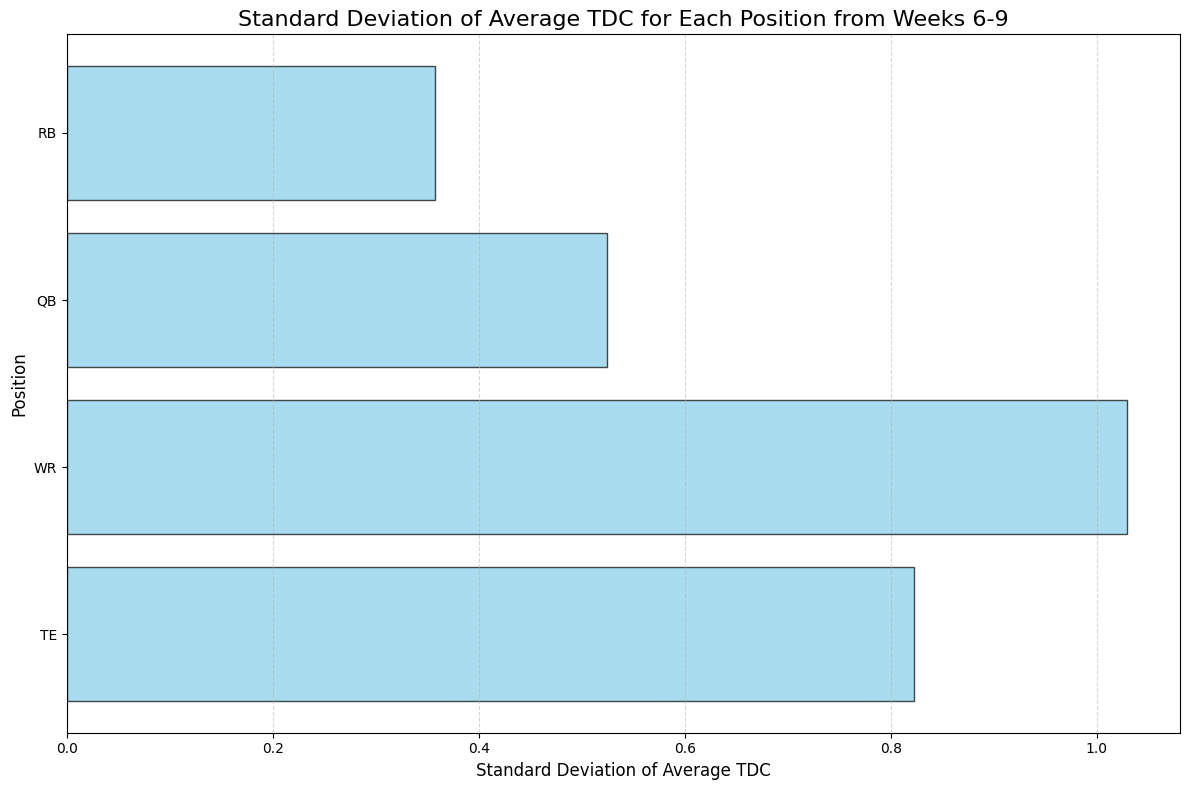

In [611]:
std_deviation_per_position = {}

for position, data in grouped_players.items():
    if position == 'FB':
        continue
    gains_list = [player['average_gain'] for player in data]
    std = np.array(gains_list).std()
    std_deviation_per_position[position] = std

# Create a stylish horizontal bar chart
positions = list(std_deviation_per_position.keys())
std_deviation_values = list(std_deviation_per_position.values())

plt.figure(figsize=(12, 8))
plt.barh(positions, std_deviation_values, color='skyblue', edgecolor='black', linewidth=1, alpha=0.7)
plt.xlabel('Standard Deviation of Average TDC', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.title('Standard Deviation of Average TDC for Each Position from Weeks 6-9', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/kaggle/working/std_chart.png')

In [612]:
FileLink('/kaggle/working/std_chart.png')

/kaggle/working/std_chart.png

In [610]:
working_directory = '/kaggle/working/'

# List all files in the working directory
files = os.listdir(working_directory)

# Iterate through the files and remove each one
for file in files:
    file_path = os.path.join(working_directory, file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [ ]:
top_ten_scorers

In [596]:
for position, players in top_ten_scorers.items():
    print(f"\nTop 10 Scorers for Position: {position}")
    for player in players:
        display_name = player['displayName']
        average_gain = player['average_gain']
        print(f"Display Name: {display_name}, Position: {position}, Average Gain: {average_gain}")


Top 10 Scorers for Position: TE
Display Name: Greg Dulcich, Position: TE, Average Gain: 2.0788722784665183
Display Name: Daniel Bellinger, Position: TE, Average Gain: 1.4914566296731766
Display Name: Foster Moreau, Position: TE, Average Gain: 1.4348175038294952
Display Name: Cade Otton, Position: TE, Average Gain: 1.2808861148460204
Display Name: George Kittle, Position: TE, Average Gain: 1.072344059830792

Top 10 Scorers for Position: WR
Display Name: Chris Olave, Position: WR, Average Gain: 1.863204970983666
Display Name: Laviska Shenault, Position: WR, Average Gain: 0.7786718663132077
Display Name: Deebo Samuel, Position: WR, Average Gain: 0.7330168802550193
Display Name: Rondale Moore, Position: WR, Average Gain: 0.5438767940026222
Display Name: Terry McLaurin, Position: WR, Average Gain: 0.515102973797285

Top 10 Scorers for Position: FB
Display Name: Kyle Juszczyk, Position: FB, Average Gain: 1.6068010286041159

Top 10 Scorers for Position: QB
Display Name: Daniel Jones, Positio

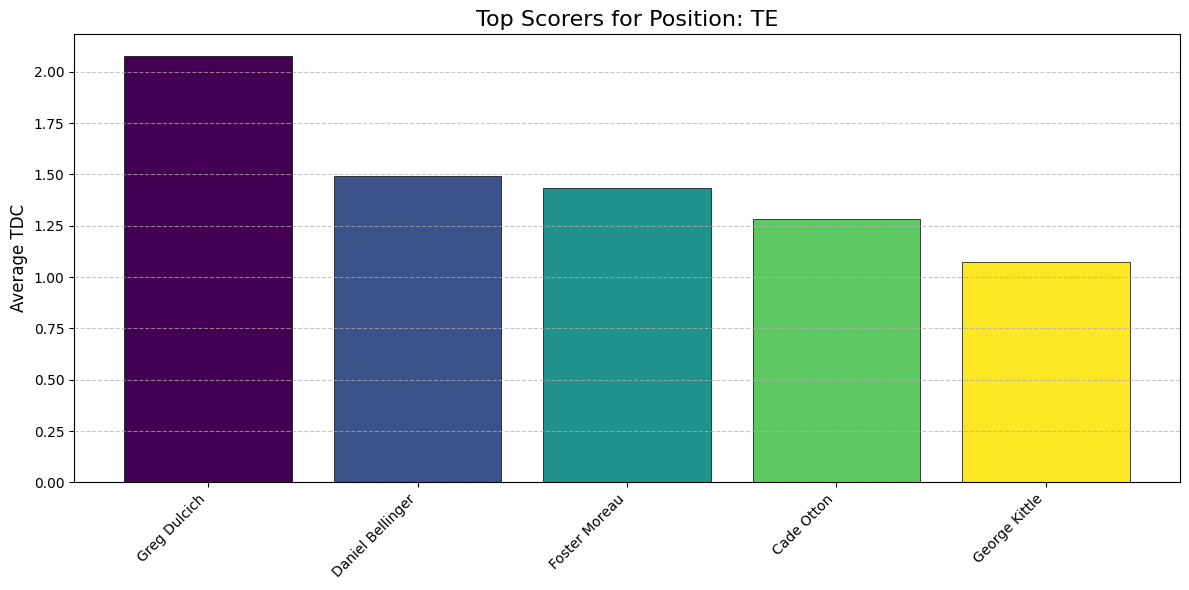

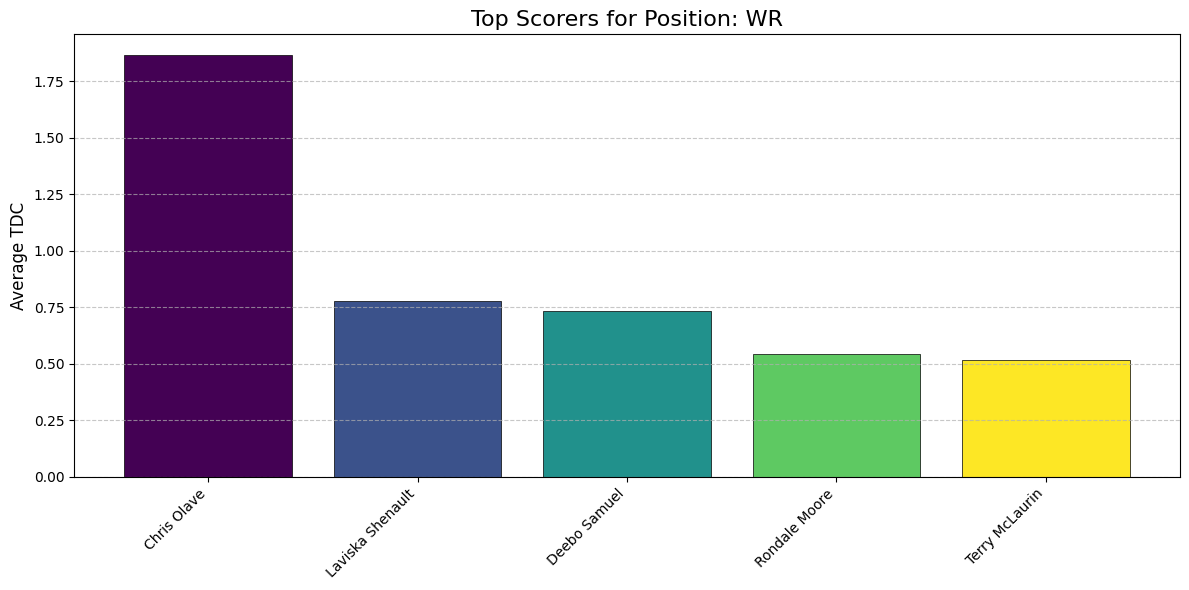

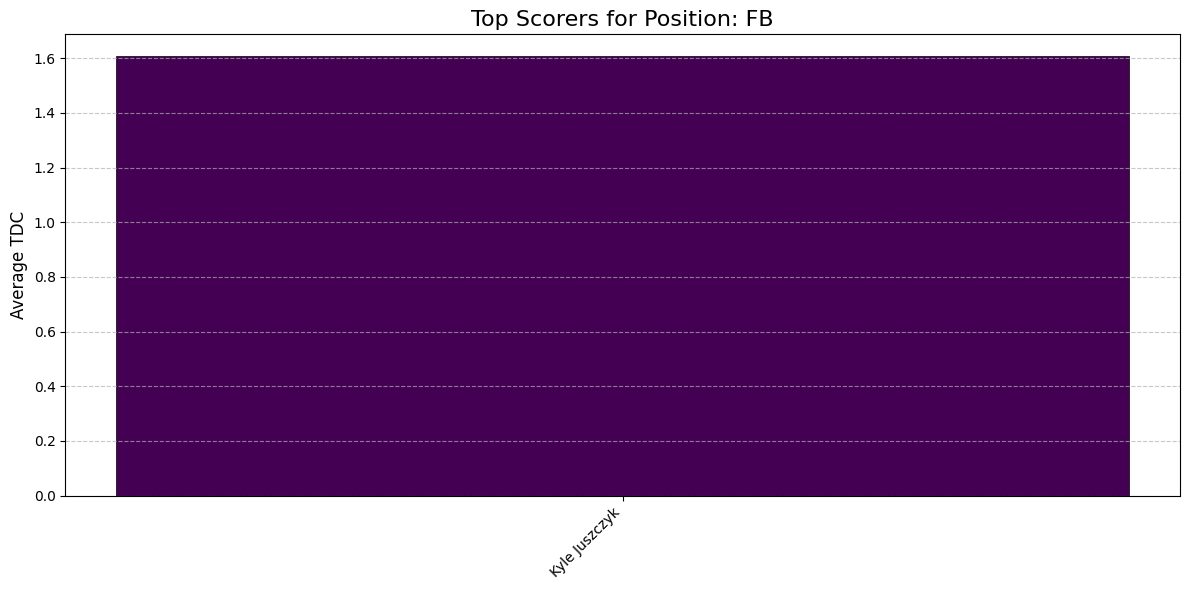

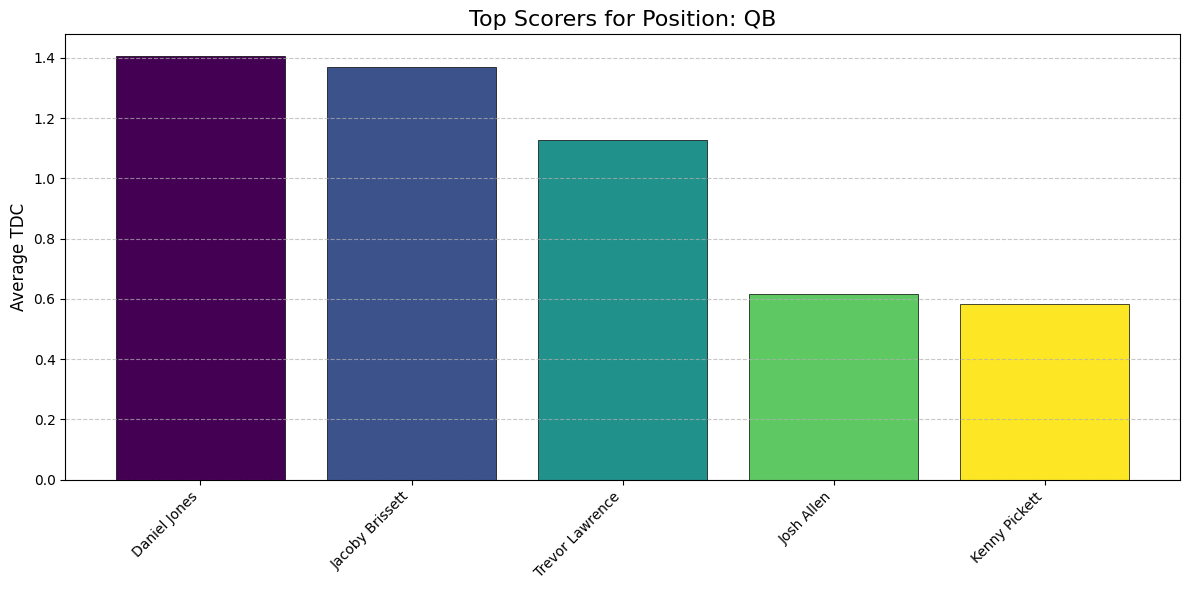

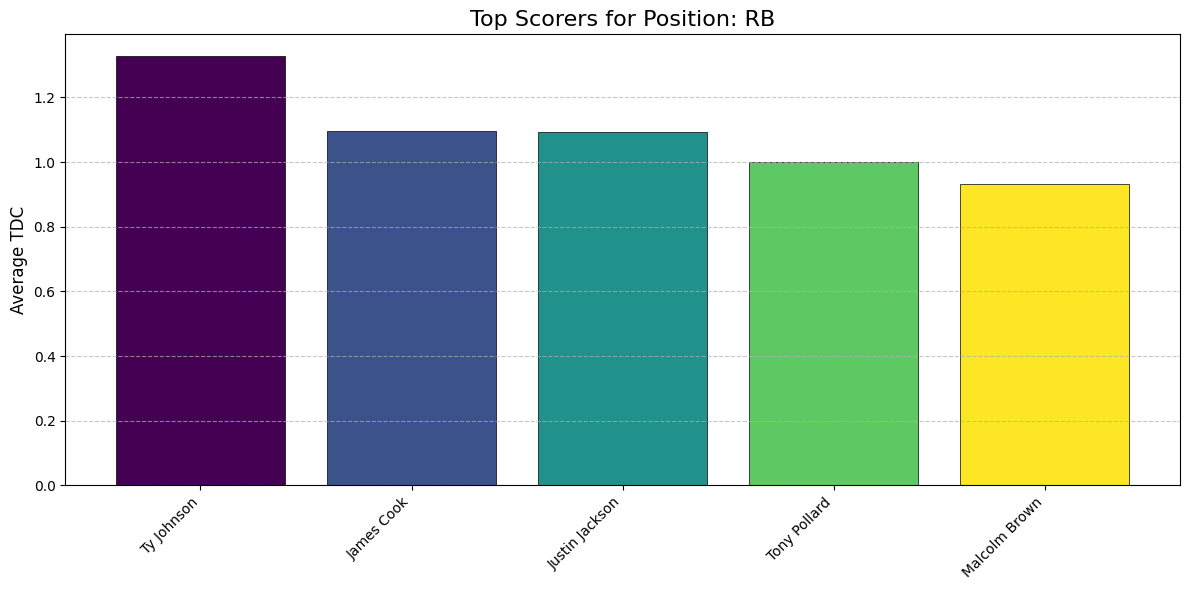

In [566]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.viridis(np.linspace(0, 1, len(top_ten_scorers)))

for position, players in top_ten_scorers.items():
    # Extract display names and average gains
    display_names = [player['displayName'] for player in players]
    average_gains = [player['average_gain'] for player in players]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(display_names, average_gains, color=colors, edgecolor='black', linewidth=0.5)

    # Add labels and title
    #plt.xlabel('Name', fontsize=12)
    plt.ylabel('Average TDC', fontsize=12)
    plt.title(f'Top Scorers for Position: {position}', fontsize=16)

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    #plt.legend(bars, [f'{name}' for name in display_names], title='Display Names', loc='upper left', bbox_to_anchor=(1, 1))

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'/kaggle/working/top_scorers_{position}.png')

    # Show or save the plot
    #plt.show()

In [169]:
with open('/kaggle/working/valid_frames_list_with_preds.pkl', 'wb') as f:
    pickle.dump(valid_frames_list, f)